# Introduction of Dark Matter: Exercise

In [1]:
%matplotlib widget

In [4]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

## 1 Dark Matter (DM) density profile

### 1.1

In [5]:
r_s = 24.42 # kpc
rho_s = 0.184 # GeV cm^{-3}
r_sun = 8.4 # kpc

In [6]:
def rho_NFW(r):
    """
    Parameters
    ----------
    r : float
        The radius from the GC in kpc.
    
    Returns
    -------
    rho_NFW : float
        The DM density in unit GeV cm^{-3}
    """
    x = r / r_s
    return rho_s / (x * np.power(1 + x, 2))

In [7]:
c = 299792458*u.m/u.s
G = 6.6743e-11*u.m**3/(u.kg*u.s**2) # m^3 kg^{-1} s^{-2}
M_BH = 4.154e6*u.M_sun 
R_sch = 2*G*M_BH/c**2
R_vir = 200*u.kpc
r_min = 2*R_sch
r_min_kpc = r_min.to(u.kpc).value
R_vir_kpc = R_vir.to(u.kpc).value
log10_r_min_kpc = np.log10(r_min_kpc)
log10_R_vir_kpc = np.log10(R_vir_kpc)
r = np.logspace(log10_r_min_kpc, log10_R_vir_kpc, int((log10_R_vir_kpc - log10_r_min_kpc)/0.1))

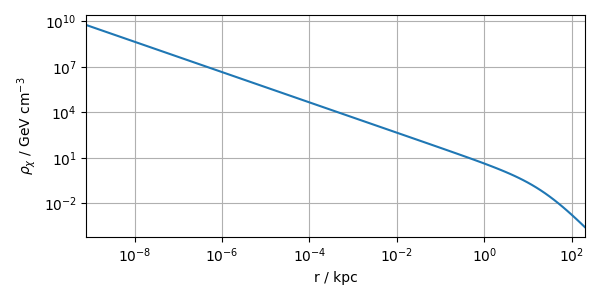

In [8]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
ax.plot(r, rho_NFW(r), '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'r / kpc')
ax.set_ylabel(r'$\rho_\chi$ / GeV cm$^{-3}$')
ax.set_xlim(r_min_kpc, R_vir_kpc)
ax.grid(which='both')
fig.tight_layout()
fig.savefig('/home/mwolf/rho_of_r.png')
plt.show()

### 1.2

Solve on paper.

In [9]:
def r_of_l_psi(l, psi):
    """Calculates the distance r from the GC given the l-o-s length l and angle
    psi.

    Parameters
    ----------
    l : array of float
        The l-o-s length l in kpc.
    psi : float
        The l-o-s angle psi in radian.

    Returns
    -------
    r : array of float
        The distance r from the GC. 
    """
    return np.sqrt(l**2 - 2*l*r_sun*np.cos(psi) + r_sun**2)

In [10]:
psi = np.deg2rad(0)
l = np.logspace(np.log10(0.1), np.log10(200), int((np.log10(200)-np.log10(0.1))/0.1))
r = r_of_l_psi(l=l, psi=psi)

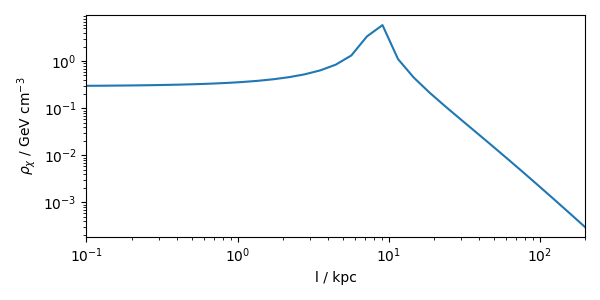

In [11]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
ax.plot(l, rho_NFW(r), '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'l / kpc')
ax.set_ylabel(r'$\rho_\chi$ / GeV cm$^{-3}$')
ax.set_xlim(np.min(l), np.max(l))
fig.tight_layout()
plt.show()

## 2 J-Factor and flux 

### 2.1

Solve on paper.

### 2.2

In [12]:
from scipy import integrate

In [13]:
def rho_chi(r):
    """Calculates the DM density rho_chi given in eq (1).
    
    Parameters:
    -----------
    r : float | array of float
        The distance from the GC in kpc.
    
    Returns
    -------
    rho_chi : array of float
        The DM density in GeV cm^{-3}.
    """
    r = np.atleast_1d(r)
    
    m = (r > 2*R_sch.to(u.kpc).value) & (r <= R_vir.to(u.kpc).value)
    
    rho_chi = np.zeros_like(r)
    rho_chi[m] = rho_NFW(r=r[m])
    
    return rho_chi

In [16]:
def rho_chi_of_l_psi(l, psi):
    r = r_of_l_psi(l=l, psi=psi)
    return rho_chi(r=r)

def l_integrand(l, psi):
    rho_sun = rho_chi(r=r_sun)[0]
    return 1 / r_sun * np.power(rho_chi_of_l_psi(l=l, psi=psi) / rho_sun, 2)

def l_integral(psi, l_min, l_max):
    res = integrate.quad(l_integrand, l_min, l_max, args=(psi,))
    return res[0]

def psi_integrand(psi, l_min, l_max):
    return np.sin(psi) * l_integral(psi=psi, l_min=l_min, l_max=l_max)

def psi_integral(l_min, l_max):
    res = integrate.quad(psi_integrand, 0, np.pi, args=(l_min, l_max))
    return res[0]

def J(l_min, l_max):
    return 2*np.pi * psi_integral(l_min=l_min, l_max=l_max)

In [22]:
l_min = 0
l_max = R_vir_kpc + r_sun
print(f'l_min = {l_min} kpc')
print(f'l_max = {l_max} kpc')
j_factor = J(l_min=l_min, l_max=l_max)
print(f'J factor = {j_factor}')

l_min = 0 kpc
l_max = 208.4 kpc
J factor = 34.67784905386016


### 2.3

Integration over all energies of $\frac{dN_{\gamma}}{dE} \equiv 2\delta(E - m_\chi)$ gives $N_{\gamma}=2$.

In [32]:
rho_sun = rho_chi(r=r_sun)[0] # GeV cm^3
N_gamma = 2
Phi_gamma = (r_sun*u.kpc).to(u.cm) / (4*np.pi*2) * (3e-26*u.cm**3/u.s) * (rho_sun*u.GeV*u.cm**(-3)/(300*u.GeV))**2 * N_gamma * j_factor
print(f'Phi_gamma = {Phi_gamma}')

Phi_gamma = 2.090968975572972e-09 1 / (cm2 s)


## 3 Spike structure

In [33]:
R_sp_kpc = 1/1000
gamma_sp = 7/3

In [34]:
def rho_sp(r):
    """Calculates the spike DM density profile in unit GeV cm^{-3}.

    Parameters
    ----------
    r : array of float
        The distance from the GC in kpc.
    
    Returns
    -------
    rho_sp : array of float
        The spike DM density in GeV cm^{-3}. 
    """
    r = np.atleast_1d(r)

    return rho_NFW(r=R_sp_kpc) * np.power(r/R_sp_kpc, -gamma_sp)

### 3.2

Solving the differential equation by separating the variables.

$\int_{n_{\chi}(r,t_f)}^{n_{\chi}(r,t)} \frac{1}{n_{\chi}'^2}dn_{\chi}' = -\int_{t_f}^{t} \left<\sigma v\right> dt'$